In [3]:
import pandas as pd
import numpy as np
import json
import re
import random
import collections
import itertools 
import requests
from bs4 import BeautifulSoup
import random 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [4]:
json_file_path = 'TVs-all-merged.json'
with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

In [5]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_television_manufacturers"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
df=pd.read_html(str(indiatable))
brandList = list(df[0]['Company'])
brandList.append('LG')
brandList.append('Panasonic')
brandList.append('VIZIO')
brandList.append('Naxa')

In [6]:
def adj_dict(original_dict):
    new_dict = {}
    product_id = 1
    for key in original_dict.keys():
        for val in original_dict[key]:
            new_dict[str(product_id)] = val
            product_id += 1
    return new_dict

def adj_dict2(original_dict):
    new_dict = {}
    product_id = 1
    for key in original_dict.keys():
        new_dict[str(product_id)] = original_dict[key]
        product_id += 1
    return new_dict

def bootstrap(dictionary):
    s = pd.Series(dictionary)
    training_data , test_data  = [i.to_dict() for i in train_test_split(s, train_size=0.63)]
    return training_data

def get_duplicates(new_dict):
    model_pairs_dict = {}
    duplicates = set()
    for key in new_dict.keys():
        modelID = new_dict[key]['modelID']
        if not modelID in model_pairs_dict:
            model_pairs_dict[modelID] = []
            model_pairs_dict[modelID].append(key) 
        else:
            model_pairs_dict[modelID].append(key)
    for val in model_pairs_dict.values():
            if len(val) > 1:
                for pair in itertools.combinations(val,2):
                    duplicates.add(pair)
    return duplicates
    
def isModelID(string):
    return bool(re.search(r'\d', string) and (re.search('[a-zA-Z]', string)) and string.isupper())

def isModelWordTitle(string):
    regex = re.compile('[a-zA-Z0-9]*(([0-9]+[ˆ0-9, ]+)|([ˆ0-9, ]+[0-9]+))[a-zA-Z0-9]*')
    return bool(regex.search(string))

def isModelWordFeature(string):
    regex =  re.compile('ˆ\d+(\.\d+)?[a-zA-Z]+$|ˆ\d+(\.\d+)?$')
    return bool(regex.search(string))

def jaccard(MW1, MW2):
    return len(MW1.intersection(MW2)) / len(MW1.union(MW2))

def modelIDFromTitle(product):
    title_list = product['title'].split()
    candidateID = []
    for element in title_list:
        if (isModelID(element)) and (len(element) > 3): # minimum length of modelID == 4
            candidateID.append(element)
    if len(candidateID) > 0:
        return max(candidateID, key=len)
    else:
        return 'NA'
    
def candidates_fromModelID(dictionary):
    candidates_set = set()
    for product_i in dictionary.keys():
        for product_j in dictionary.keys():
            if (product_i != product_j) and (dictionary[product_i]['shop'] != dictionary[product_j]['shop']): 
                modelID_i = dictionary[product_i]['extrModelID']
                modelID_j = dictionary[product_j]['extrModelID']
                if (modelID_i == modelID_j) and (modelID_i != 'NA') and (modelID_j != 'NA'):
                    if int(product_i) < int(product_j):
                        candidates_set.add((product_i, product_j))
                    else:
                        candidates_set.add((product_j, product_i))
    return candidates_set

def brandAndModelID(dictionary):
    for key in dictionary.keys():
        dictionary[key]['extrModelID'] = modelIDFromTitle(dictionary[key])
        dictionary[key]['brand'] = get_Brand(dictionary[key])
    return dictionary
    
def get_Brand(product):
    for brand in brandList:
        title = product['title']
        url = product['url']
        if (brand in title) or (brand in url):
            return brand
        elif 'Brand' in product['featuresMap']:
            return product['featuresMap']['Brand']

def get_ModelWords(dictionary):
    mw_set = set()
    for key in dictionary.keys():
        title_list = dictionary[key]['title'].split()
        for string in title_list:
            if (isModelWordTitle(string)):
                t_string = re.sub("[^0-9]",'',string)
                mw_set.add(t_string)
        for feature in dictionary[key]['featuresMap']:
            feature_list = dictionary[key]['featuresMap'][feature].split()
            for string in feature_list:
                if(isModelWordFeature(string)):
                    f_string = re.sub("[^0-9]",'',string)
                    mw_set.add(f_string)
    return list(mw_set)

def MW_title(title):
    mw_set = set()
    title_list = title.split()
    for string in title_list:
        if (isModelWordTitle(string)):
            t_string = re.sub("[^0-9]",'',string)
            mw_set.add(t_string)
    return mw_set

def binary_matrix(dictionary):
    modelWords = get_ModelWords(dictionary)
    binary_matrix = np.zeros((len(modelWords), len(dictionary)), dtype='int')
    prod_idx = 0
    for key in dictionary.keys():
        title = dictionary[key]['title']
        for feature in dictionary[key]['featuresMap'].values():
            mw_idx = 0
            for mw in modelWords:
                if (mw in title) or (mw in feature):
                    binary_matrix[mw_idx][prod_idx] = 1
                mw_idx+=1
        prod_idx+=1
    return binary_matrix

def minHash(binary_matrix, nPermutations=100):
    nModelWords, nProducts = binary_matrix.shape
    init = np.arange(1, (nModelWords+1))
    S = np.empty((nPermutations, nProducts), int)

    for idx in range(nPermutations):
        random.shuffle(init)
        for prod in range(nProducts):
            for perm in range(len(init)):
                index = np.where(init == perm+1)[0][0]
                if binary_matrix[index][prod] == 1:
                    S[idx][prod] = init[index]
                    break
    return S
    
def LSH(sign_mat, b=20, r=5):
    n, products = sign_mat.shape
    assert n==b*r
    bands = np.array_split(sign_mat, b, axis=0)
    hash_buckets = collections.defaultdict(set)
    candidate_pairs = set()
    for idx,band in enumerate(bands):
        for prod in range(products):
            band_idx = [str(idx)]
            band_sig = list(band[:,prod])
            band_prod_idx = tuple(band_sig + band_idx)
            hash_buckets[band_prod_idx].add(prod+1)
    for bucket_val in hash_buckets.values():
        if len(bucket_val) > 1:
            for combination in itertools.combinations(bucket_val,2):
                candidate_pairs.add(combination)
    cp_list = list(candidate_pairs)
    for idx in range(len(cp_list)):
        cp_list[idx] = tuple(sorted(cp_list[idx]))
        cp_list[idx] = str(cp_list[idx][0]), str(cp_list[idx][1])
    return set(cp_list)

def sim_mat(dictionary, LSH_cand, EMID_cand):
    nItems = len(dictionary)
    result = np.full((nItems, nItems), 100, dtype=float)
    np.fill_diagonal(result,0)

    for pair in list(LSH_cand):
        item1 = pair[0]
        item2 = pair[1]
        mw_title_1 = MW_title(dictionary[item1]['title'])
        mw_title_2 = MW_title(dictionary[item2]['title'])
        shop_1 = dictionary[item1]['shop']
        shop_2 = dictionary[item2]['shop']
        brand_1 = dictionary[item1]['brand']
        brand_2 = dictionary[item2]['brand']

        result[int(item1)-1, int(item2)-1] = 1 - jaccard(mw_title_1, mw_title_2)
        if (shop_1 == shop_2) or (brand_1 != brand_2):
            result[int(item1)-1, int(item2)-1] = 100
        result[int(item2)-1, int(item1)-1] = result[int(item1)-1, int(item2)-1]

    for pair in list(EMID_cand):
        item1 = pair[0]
        item2 = pair[1]
        result[int(item1)-1, int(item2)-1] = 0
        result[int(item2)-1, int(item1)-1] = result[int(item1)-1, int(item2)-1]
        
    return result

def Clustering(sim_matrix):
    threshold = 0.5
    linkage = AgglomerativeClustering(n_clusters=None, affinity="precomputed", linkage='average', distance_threshold=threshold)
    clusters = linkage.fit_predict(sim_matrix)
    cluster_dict = {}
    for idx, clusterid in enumerate(clusters):
        if clusterid in cluster_dict:
            cluster_dict[clusterid] = np.append(cluster_dict[clusterid], idx)
        else:
            cluster_dict[clusterid] = np.array([idx])
    candPairs = set()
    for candidate in cluster_dict.values():
        if len(candidate) > 1:
            for i, item1 in enumerate(candidate):
                for j in range(i + 1, len(candidate)):
                    if (candidate[i] < candidate[j]):
                        candPairs.add((str(candidate[i]+1), str(candidate[j]+1)))
                    else:
                        candPairs.add((str(candidate[j]+1), str(candidate[i]+1)))
    return candPairs

def Results(candidates, duplicates, LSH_cand, N):
    candidates_list = list(candidates) 
    TP = 0 
    for candidate in candidates_list:
        if candidate in duplicates:
            TP += 1
            
    FP = len(candidates_list) - TP
    FN = len(duplicates) - TP
    pairCompl=TP/len(duplicates)
    pairQual=TP/len(candidates_list)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1=2*(precision*recall)/(precision+recall)
    F1star=2*(pairQual*pairCompl)/(pairQual+pairCompl)
    fraction=(len(LSH_cand)/(N*(N-1))/2)
    
    return [pairCompl, pairQual, F1, fraction]

In [7]:
def main(data):
    train_dict = adj_dict(data)
    train_dict = brandAndModelID(train_dict)
    b_vals = [400, 200, 100, 80, 50, 40, 25, 10, 5]
    n_val = 400
    results = np.zeros((len(b_vals), 4))
    for i in range(len(b_vals)):
        r_val = int(n_val / b_vals[i])
        results[i] = run(train_dict, n_val, b_vals[i], r_val)
    return results

In [8]:
def run(dictionary, n, b, r, nBootstraps=5):
    results = np.zeros((nBootstraps, 4))
    for i in range(nBootstraps):
        train_data = bootstrap(dictionary)
        train_data = adj_dict2(train_data)
        duplicates = get_duplicates(train_data)
        candidates = candidates_fromModelID(train_data)
        bin_mat = binary_matrix(train_data)
        sig_mat = minHash(bin_mat, n)
        candidates_LSH = LSH(sig_mat, b, r)
        similarities = sim_mat(train_data, candidates_LSH, candidates)
        final_pairs = Clustering(similarities)
        results[i] = Results(final_pairs, duplicates, candidates_LSH, len(train_data))
    return np.mean(results,axis=0)

In [9]:
def graphs(results):
    y_labels = ['Pair Completeness (recall)', 'Pair Quality', 'F1-measure']
    idxs = [0, 1, -2]
    for i in range(len(y_labels)):
        plt.figure()
        x = result_matrix[:,-1]
        y = result_matrix[:,idxs[i]]
        y_EMID = result_matrix[:,idxs[i]][-1]
        plt.xlabel('Fraction of Comparisons')
        plt.ylabel(y_labels[i])
        plt.plot(x,y, color='black')
        plt.axhline(y_EMID, color = 'grey', linestyle = 'dashed', label = "EMID") 
        plt.legend()
        plt.plot()

In [10]:
result_matrix = main(contents)

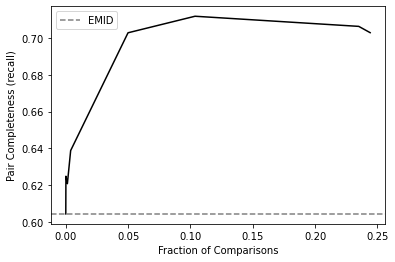

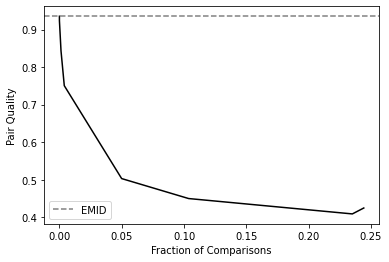

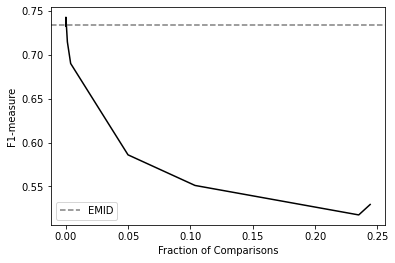

In [11]:
graphs(result_matrix)